<a href="https://colab.research.google.com/github/palVikram/Advance_tensorflow/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
import os
import zipfile 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.optimizers import RMSprop

In [ ]:
import urllib.request
from shutil import copyfile 
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url,data_file_name)

('catsdogs.zip', <http.client.HTTPMessage at 0x7fa80b4d5c10>)

In [ ]:
zip_ref=zipfile.ZipFile(data_file_name,'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [ ]:
print("Number of cat images:",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images:", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images: 12501
Number of dog images: 12501


In [ ]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [ ]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"

train_datagen=ImageDataGenerator(rescale=1/.255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2, 
                                 horizontal_flip=True,
                                 fill_mode='nearest'
                                 )
train_generator=train_datagen.flow_from_directory(TRAINING_DIR,
                                                  batch_size=100,
                                                  class_mode='binary',
                                                  target_size=(150,150)
                                                  )

Found 22498 images belonging to 2 classes.


In [ ]:
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

test_datagen=ImageDataGenerator(rescale=1/.255)
test_generator=test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size=100,
                                                  class_mode='binary',
                                                  target_size=(150,150)
                                                  )


Found 2500 images belonging to 2 classes.


In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7fa80a1a8090>)

In [ ]:
pretrained_model=inception_v3.InceptionV3(input_shape=(150,150,3),
                            include_top=False,
                            weights=None)

pretrained_model.load_weights(weights_file)

for layer in pretrained_model.layers:
  layer.trainable=False

last_layer=pretrained_model.get_layer("mixed7")
print('last layer output shape: ', last_layer.output_shape)

last_output=last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
### Flatten the output to 1 dimension
x=layers.Flatten()(last_output)
## Add a fully connected layer with 1,024 hidden units and ReLU activation
x=layers.Dense(1024,activation="relu")(x)

### add a sigmoid layer for classificaiton
output=layers.Dense(1, activation="sigmoid")(x)

model=Model(pretrained_model.inputs, output)

In [ ]:

# compile the model
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,
            validation_data=test_generator,
            epochs=2,
            verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/2
146/225 [==================>...........] - ETA: 4:10 - loss: 65.9288 - acc: 0.5469

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 785s 3s/step - loss: 49.2092 - acc: 0.5496 - val_loss: 8.9022 - val_acc: 0.6372
Epoch 2/2
225/225 [==============================] - 777s 3s/step - loss: 8.7562 - acc: 0.5678 - val_loss: 2.9883 - val_acc: 0.6512


<Figure size 432x288 with 0 Axes>

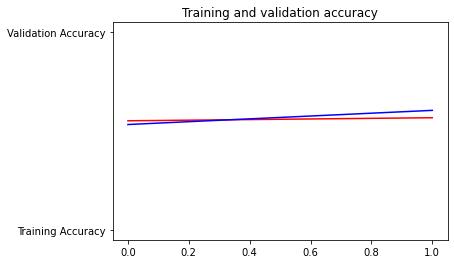

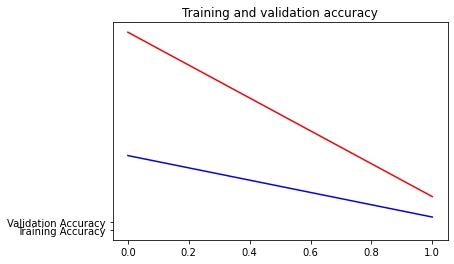

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

### Number of epoch
epochs=range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Accuracy")
plt.plot(epochs, val_loss, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [14]:
### prediction
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")


Saving photo-1615789591457-74a63395c990.jpg to photo-1615789591457-74a63395c990.jpg
[[0.7275946]]
[0.7275946]
photo-1615789591457-74a63395c990.jpg is a dog
